# Cvičení 07b - Hugging Face
Hugging Face je otevřená platforma a komunita, která se rychle stala centrem pro výzkum a nasazení moderních modelů hlubokého učení (Deep Learning), zejména v oblasti zpracování přirozeného jazyka (NLP), ale nyní i počítačového vidění.

Jádrem platformy je knihovna transformers, která poskytuje rozsáhlý katalog předtrénovaných modelů state-of-the-art (jako jsou BERT, GPT, ViT, Diffusion Models) a umožňuje jejich snadné stahování, úpravu a spouštění pomocí frameworků PyTorch a TensorFlow.

Hugging Face usnadňuje vědcům a inženýrům sdílení modelů, datasetů a demoverzí, čímž výrazně urychluje přechod od akademického výzkumu k praktickým aplikacím.

## Krok 1. Instalace a importy

In [1]:
!pip install diffusers transformers accelerate torch Pillow
print("Knihovny nainstalovány.")

import torch
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

Knihovny nainstalovány.


### Proč se importuje co:

**import torch** - Nezbytný pro práci s tenzory, výpočty na GPU (CUDA) a pro manipulaci s modely, které jsou v PyTorch implementovány.

**from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler** - Modul difuzních modelů: Toto je specializovaná knihovna, která poskytuje:
- **StableDiffusionPipeline**: Hlavní třída, která automatizuje celý proces generování (načítání VAE, U-Net, Text Encoderu, a jejich koordinaci).
- **DPMSolverMultistepScheduler**: Algoritmus, který řídí *proces odšumování*.

**import matplotlib.pyplot as plt** - Vizualizace pro vykreslení mezikroků difuze a finálního obrázku přímo v notebooku.

**from PIL import Image** - Manipulace s obrázky: Používá se pro načítání a ukládání obrázku v paměti a pro zpracování obrazového výstupu z VAE dekodéru.

**import numpy as np** - Práce s poli.

## 2. Načtení modelu a scheduleru

In [2]:
# Načtení modelu SD 1.5 z Hugging Face
MODEL_ID = "runwayml/stable-diffusion-v1-5"

# Nastavení scheduleru pro rychlejší generování
scheduler = DPMSolverMultistepScheduler.from_pretrained(MODEL_ID, subfolder="scheduler")

# Vytvoření Pipeline a přesun na GPU
pipe = StableDiffusionPipeline.from_pretrained(MODEL_ID, scheduler=scheduler, dtype=torch.float16)
device = "cuda" if torch.cuda.is_available() else "cpu"
pipe.to(device)

print(f"Stable Diffusion 1.5 Pipeline načteno na: {device}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

safety_checker/model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Keyword arguments {'dtype': torch.float16} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Stable Diffusion 1.5 Pipeline načteno na: cuda


**StableDiffusionPipeline** je hlavní třída, která automaticky načte všechny komponenty modelu (VAE, U-Net a Text Encoder).

Argument **torch_dtype=torch.float16** přepíná model do poloviční přesnosti (FP16), což výrazně šetří paměť GPU a zrychluje výpočty.

**DPMSolverMultistepScheduler** -- Tento scheduler používá pokročilé metody řešení diferenciálních rovnic, což mu umožňuje dosáhnout vysoké kvality výsledku za výrazně menšího počtu kroků (např. 20–50 kroků) ve srovnání se staršími schedulery (které vyžadovaly 1000+ kroků). Zajišťuje tedy rychlost a kvalitu.

## Krok 2. Funkce pro zobrazení mezivýsledků

Využíváme 'callback' pro zachycení latentních stavů během odšumování.

In [5]:
# %%
def visualize_diffusion_process(pipe, prompt, num_inference_steps=50, steps_to_capture=10):
    """Generuje obrázek a vizualizuje mezikroky difuze."""

    latent_steps = []

    def capture_latent_callback(pipe, step_index, timestep, callback_kwargs):
        # Callback kwargs se používá pro přístup k latents

        # Ukládáme stav po každém 'steps_to_capture' kroku
        if step_index % steps_to_capture == 0:
            # Získání latentního stavu z kwargs
            latents = callback_kwargs['latents']

            # Dekódujeme latentní stav na pixely pomocí VAE Dekodéru
            with torch.no_grad():
                # VAE dekóduje latenty na pixely
                image = pipe.vae.decode(latents / pipe.vae.config.scaling_factor, return_dict=False)[0]

            # Přesun na CPU a normalizace
            image = pipe.image_processor.postprocess(image, output_type="pil")

            # Ukládáme jen první obrázek z dávky [0]
            latent_steps.append((step_index, image[0]))

        return callback_kwargs

    print(f"Spouštím generování pro {num_inference_steps} kroků, ukládám každých {steps_to_capture} kroků.")

    # Spuštění generování. Používáme novou syntaxi 'callback_on_step_end' a 'callback_steps'
    final_result = pipe(
        prompt=prompt,
        num_inference_steps=num_inference_steps,
        # POZOR: Změna argumentů na moderní callback syntaxi
        callback_on_step_end=capture_latent_callback,
        callback_on_step_end_tensor_inputs=['latents'], # Specifikujeme, které tensory chceme
        callback_steps=1,
        output_type="pil"
    ).images[0]

    return final_result, latent_steps

Funkce **visualize_diffusion_process** slouží k vizualizaci zpětné difuze (odšumování) krok za krokem, aby bylo vidět, jak se obraz vyvíjí z latentního šumu.
- Přijímá celou *pipe* (model SD), textový *prompt* a definuje parametry tréninku (počet kroků *num_inference_steps*).
- do seznamu **latent_steps** ukládá dvojice (*číslo kroku*, *obrázek*).

Vnitřní callback funkce **capture_latent_callback**
- spustí se po dokončení každého kroku odšumování (řízeno **callback_steps=1**).
- callback funkce přijímá vnitřní parametry stavu, včetně **step_index** (aktuální krok scheduleru) a **callback_kwargs**, které obsahují aktivní tenzory (zde **'latents'**).

**image = pipe.vae.decode** dekóduje latent (na obrázek v tenzoru)

**pipe.image_processor.postprocess** převede ten tenzor na objekt **PIL.image** vhodný pro visualizaci.

**final_result = pipe** -- volání pipeline.

## Krok 3: Spuštění

In [6]:
PROMPT = "Steampunk coffee machine"
FINAL_STEPS = 50
CAPTURE_STEP = 10 # Ukládáme každý 10. krok

final_image, intermediate_images = visualize_diffusion_process(pipe, PROMPT, FINAL_STEPS, CAPTURE_STEP)

Spouštím generování pro 50 kroků, ukládám každých 10 kroků.


  0%|          | 0/50 [00:00<?, ?it/s]

### Výsledná vizualizace
Zobrazení mezikroků a finálního výsledku.

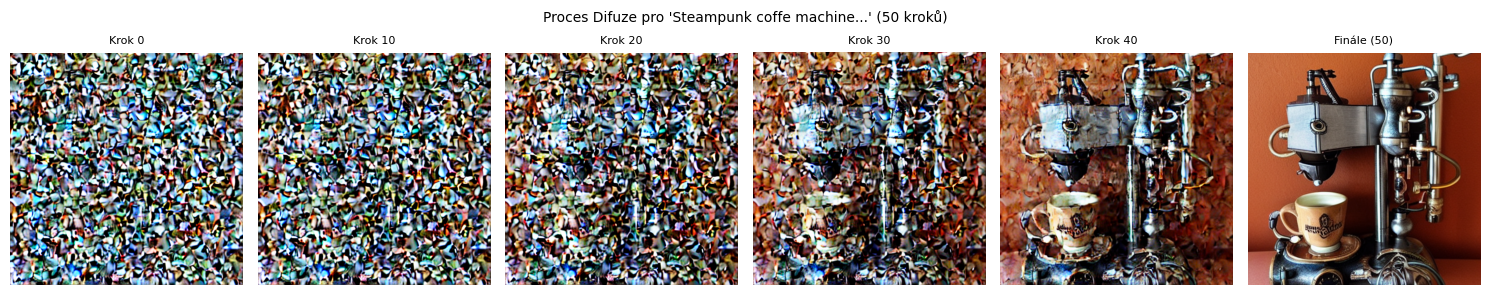

In [7]:
# Počet uložených mezikroků + finální obrázek
num_plots = len(intermediate_images) + 1
fig, axs = plt.subplots(1, num_plots, figsize=(15, 3))
fig.suptitle(f"Proces Difuze pro '{PROMPT[:40]}...' ({FINAL_STEPS} kroků)", fontsize=10)

# 1. Zobrazení mezikroků
for i, (step, img) in enumerate(intermediate_images):
    axs[i].imshow(img)
    axs[i].set_title(f"Krok {step}", fontsize=8)
    axs[i].axis('off')

# 2. Zobrazení finálního výsledku
axs[-1].imshow(final_image)
axs[-1].set_title(f"Finále ({FINAL_STEPS})", fontsize=8)
axs[-1].axis('off')

plt.tight_layout()
plt.show()